# Task 1: Quantitative Data Analysis 
1. Perform a descriptive analysis of the dataset, focusing on population characteristics relevant to death. 
2. Stratify your analysis by the outcome variable to highlight contrasts between groups. 

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
from lifelines import KaplanMeierFitter

from loguru import logger


pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# --- Defining Outcome Variable - Time to death ---
Proposed Definition: Time from Hospital Admission to Death for the Final Admission
1. Starting Point: The timestamp of admission for the final hospital stay (admittime from the admissions table for the specific hadm_id during which the patient died).
2. Endpoint: The timestamp of death recorded during that same final hospital admission (deathtime from the admissions table for that hadm_id).
3. Calculation:

`Time to Death` = `deathtime` - `admittime`

MORE ABOUT REASONING IN DETAIL IN NOTEBOOK FOR TASK_2_3

P.S. Only patients with documented in-hospital death during this final admission were labeled as deceased (hospital_expire_flag = 1) and are considered for time-to-death calculation.

## Prepare cohort: 
The function `prepare_cohort`, prepares the base dataframe by loading, preprocessing, and merging admissions and patients data.

In [ ]:
# Load helper functions to load datasets
from assessment.features_hosp import prepare_cohort

time_to_death_df, cohort_df = prepare_cohort()

2025-04-23 02:55:29.828 | INFO     | main:run_cohort_preparation_pipeline:24 - -------------------------- Running cohort preparation pipeline...
2025-04-23 02:55:29.831 | INFO     | assessment.datasets:load_admissions_data:18 - Loading admissions data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/admissions.csv
2025-04-23 02:55:31.452 | INFO     | assessment.datasets:load_admissions_data:20 - Loaded 431088 rows of admissions data.
2025-04-23 02:55:31.453 | INFO     | assessment.datasets:load_patients_data:28 - Loading patients data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/patients.csv
2025-04-23 02:55:31.634 | INFO     | assessment.datasets:load_patients_data:30 - Loaded 299777 rows of patients data.
2025-04-23 02:55:31.634 | INFO     | assessment.features_hosp:prepare_cohort:104 - Loaded 431088 rows of admissions data.
2025-04-23 02:55:31.634 | INFO     | assessment.features_hosp:prepare_cohort:105 - Loaded 299777 ro

In [3]:
cohort_df

,subject_id,hadm_id,admittime,dischtime,age,gender,race,insurance,label,dod,time_to_death,admission_type,admission_location,discharge_location
64,10001884,21268656,2125-10-18 16:50:00,2125-10-20 15:15:00,68,F,BLACK/AFRICAN AMERICAN,Medicare,0,2131-01-20 00:00:00,1919.298611,EW EMER.,EMERGENCY ROOM,HOME
75,10001884,26679629,2125-10-26 20:32:00,2125-10-27 16:28:00,68,F,BLACK/AFRICAN AMERICAN,Medicare,0,2131-01-20 00:00:00,1911.144444,EW EMER.,EMERGENCY ROOM,HOME
67,10001884,23594368,2125-11-30 16:02:00,2125-12-03 14:44:00,68,F,BLACK/AFRICAN AMERICAN,Medicare,0,2131-01-20 00:00:00,1876.331944,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE
65,10001884,21577720,2125-12-26 17:06:00,2125-12-27 16:52:00,68,F,BLACK/AFRICAN AMERICAN,Medicare,0,2131-01-20 00:00:00,1850.287500,EU OBSERVATION,EMERGENCY ROOM,0
68,10001884,24325811,2126-11-04 00:50:00,2126-11-04 12:49:00,68,F,BLACK/AFRICAN AMERICAN,Medicare,0,2131-01-20 00:00:00,1537.965278,EU OBSERVATION,EMERGENCY ROOM,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430792,19996061,26115327,2118-07-25 17:55:00,2118-07-29 13:00:00,76,M,WHITE,Other,1,2118-07-29 00:00:00,3.253472,EW EMER.,EMERGENCY ROOM,DIED
430902,19998843,24842066,2187-02-05 09:27:00,2187-02-08 17:28:00,45,M,UNKNOWN,Other,1,2187-02-08 00:00:00,2.606250,EW EMER.,EMERGENCY ROOM,DIED
430915,19999297,21439025,2162-08-14 23:55:00,2162-08-23 04:16:00,42,M,MULTIPLE RACE/ETHNICITY,Other,1,2162-08-23 00:00:00,8.003472,OBSERVATION ADMIT,EMERGENCY ROOM,DIED
430951,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00,58,M,WHITE,Other,0,2164-09-17 00:00:00,53.981250,EW EMER.,EMERGENCY ROOM,HOME


## SubTask 1: Descriptive Analysis
Perform a descriptive analysis of the dataset, focusing on population characteristics relevant to death. 

count    8316.000000
mean        9.950766
std        14.058332
min         0.000000
25%         2.081597
50%         5.797917
75%        12.606250
max       248.192361
Name: time_to_death, dtype: float64


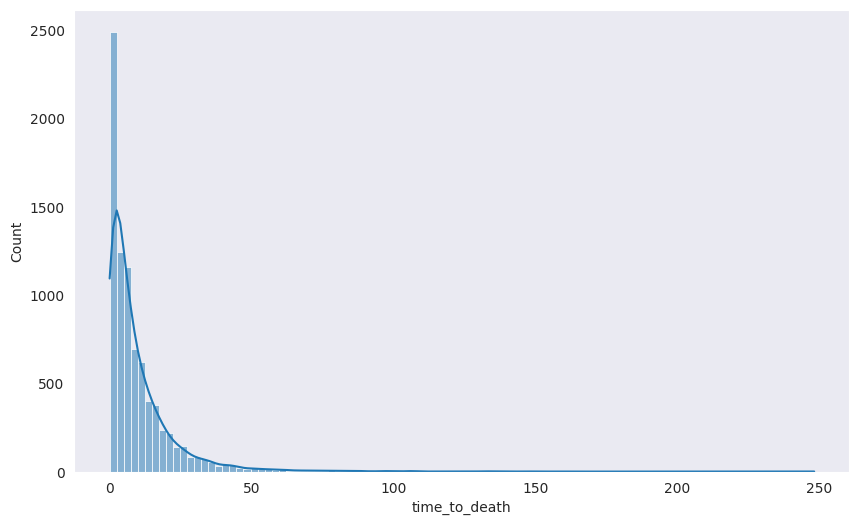

In [8]:
# Time to death Distribution
print(time_to_death_df['time_to_death'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(time_to_death_df['time_to_death'], kde = True, bins = 100)
# plt.title('Distribution of time_to_death')
# plt.xlabel('time_to_death (days)')
# plt.ylabel('Frequency')
plt.show()

## Insight:
1. Right skewed, with many daying within 0 days of admission


Age at Admission Distribution:
count    8316.000000
mean       69.955147
std        15.110156
min        18.000000
25%        60.000000
50%        72.000000
75%        82.000000
max        91.000000
Name: age, dtype: float64


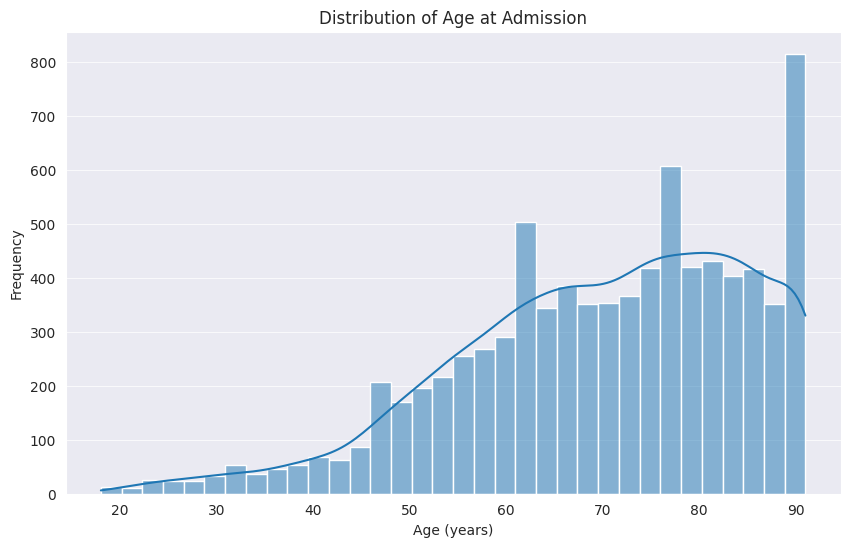


Gender Distribution:
gender
M    0.536676
F    0.463324
Name: proportion, dtype: float64


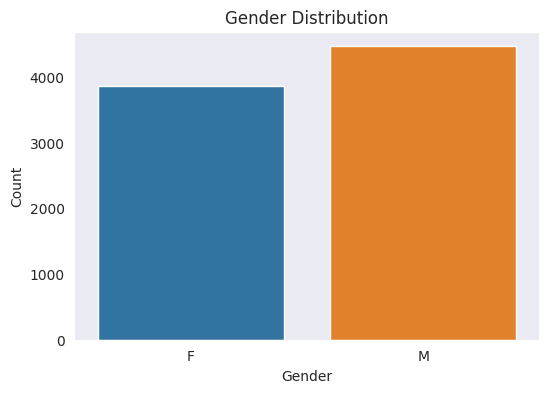


Admission Type Distribution:
admission_type
EW EMER.                       0.597884
URGENT                         0.191679
OBSERVATION ADMIT              0.130351
DIRECT EMER.                   0.047499
SURGICAL SAME DAY ADMISSION    0.014671
ELECTIVE                       0.009380
EU OBSERVATION                 0.006373
DIRECT OBSERVATION             0.001924
AMBULATORY OBSERVATION         0.000241
Name: proportion, dtype: float64


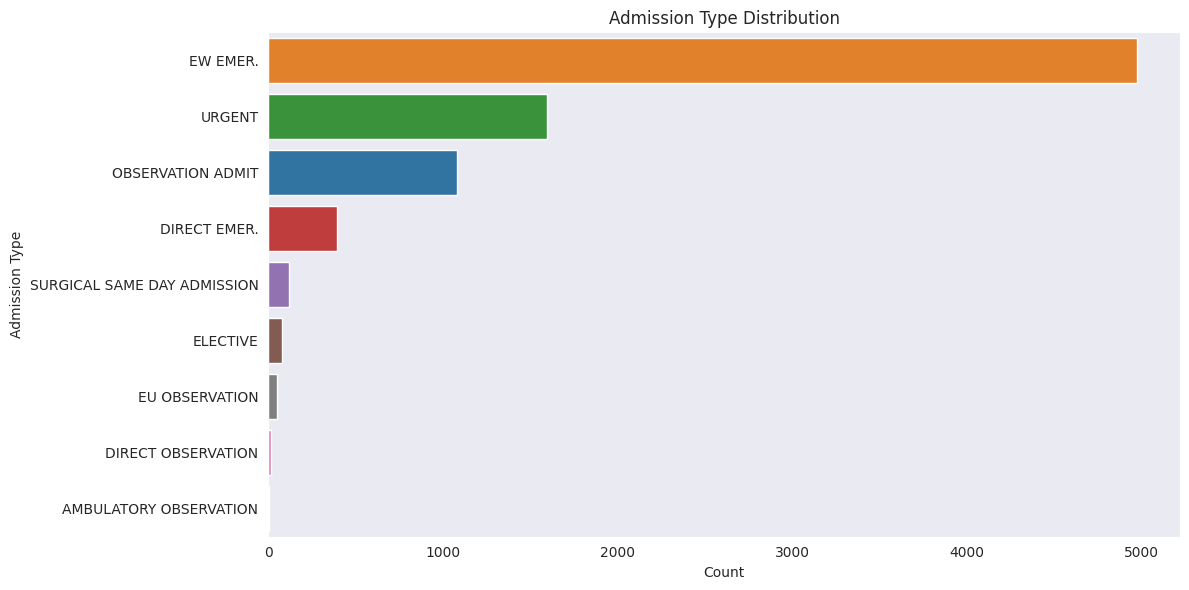

In [10]:
# Age Distribution
print("\nAge at Admission Distribution:")
print(time_to_death_df['age'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(time_to_death_df['age'], kde = True)
plt.title('Distribution of Age at Admission')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Gender Distribution
print("\nGender Distribution:")
print(time_to_death_df['gender'].value_counts(normalize=True))
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=time_to_death_df, hue='gender')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Admission Type Distribution
print("\nAdmission Type Distribution:")
print(time_to_death_df['admission_type'].value_counts(normalize=True))
plt.figure(figsize=(12, 6))
sns.countplot(y='admission_type', data=time_to_death_df, order=time_to_death_df['admission_type'].value_counts().index, hue='admission_type')
plt.title('Admission Type Distribution')
plt.xlabel('Count')
plt.ylabel('Admission Type')
plt.tight_layout()
plt.show()

## Insights:
1. Age: There's a sudden spike at Age: 91 -> Reason, MIMIC-IV caps the age at 91
2. Gender: Fairly equal distribution
3. Admission Type: Imbalnaced, with more admission type of emergency type


# Subtask 2: Stratify your analysis by the outcome variable to highlight contrasts between groups.

Stratified Analysis (by Outcome: 1=Died, 0=Censored/Survived) 

We preprocess `Patients.csv` and `Admissions.csv`


In [ ]:

from assessment.datasets import load_admissions_data, load_patients_data
admissions_df = load_admissions_data()
patients_df = load_patients_data()

merged_df = pd.merge(
    admissions_df,
    patients_df[['subject_id', 'gender', 'dod', 'anchor_age']],
    on='subject_id',
    how='left'
)

2025-04-24 09:08:34.767 | INFO     | assessment.datasets:load_admissions_data:18 - Loading admissions data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/admissions.csv
2025-04-24 09:08:36.877 | INFO     | assessment.datasets:load_admissions_data:20 - Loaded 431088 rows of admissions data.
2025-04-24 09:08:36.878 | INFO     | assessment.datasets:load_patients_data:28 - Loading patients data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/patients.csv
2025-04-24 09:08:37.107 | INFO     | assessment.datasets:load_patients_data:30 - Loaded 299777 rows of patients data.


### Preprocess to get the outcome event

Outcome is a binary flag that {1: 'Died', 0: 'Censored/Survived'}

In [17]:
# Convert date columns to datetime
merged_df['admittime'] = pd.to_datetime(merged_df['admittime'], errors='coerce')
merged_df['dischtime'] = pd.to_datetime(merged_df['dischtime'], errors='coerce')
merged_df['dod'] = pd.to_datetime(merged_df['dod'], errors='coerce') # Date of Death
merged_df['age_at_admission'] = merged_df['anchor_age']


merged_df['time_to_death'] = (merged_df['dod'] - merged_df['admittime']).dt.total_seconds() / (24 * 60 * 60)
merged_df['length_of_stay'] = (merged_df['dischtime'] - merged_df['admittime']).dt.total_seconds() / (24 * 60 * 60)

# Initialize duration and event columns
merged_df['duration'] = np.nan
merged_df['event'] = np.nan

# Identify events (death during or right at admission)
# Condition: dod is known AND dod occurs at or after admission time
mask_died = merged_df['dod'].notna() & (merged_df['time_to_death'] >= 0)

merged_df.loc[mask_died, 'event'] = 1
merged_df.loc[mask_died, 'duration'] = merged_df.loc[mask_died, 'time_to_death']

# Identify censored cases (discharged alive or dod is before admission/unknown)
# Condition: Not died OR discharge time is known
# Use length_of_stay as duration for censored events
mask_censored = ~mask_died & merged_df['length_of_stay'].notna()

merged_df.loc[mask_censored, 'event'] = 0
merged_df.loc[mask_censored, 'duration'] = merged_df.loc[mask_censored, 'length_of_stay']

# Filter out rows where duration could not be calculated or is non-positive
# (e.g., missing admittime/dischtime, or dischtime before admittime)
initial_rows = merged_df.shape[0]
merged_df = merged_df.dropna(subset=['duration', 'event'])
merged_df = merged_df[merged_df['duration'] > 0] # Duration must be positive
print(f"Filtered out {initial_rows - merged_df.shape[0]} rows with invalid/missing duration/event.")
print(f"Final cohort shape for analysis: {merged_df.shape}")


Filtered out 0 rows with invalid/missing duration/event.
Final cohort shape for analysis: (430949, 24)


### Plot the features wrt to outcome

Age at Admission by Outcome Status:


,count,mean,std,min,25%,50%,75%,max
outcome_status,,,,,,,,
Censored/Survived,325223.0,53.229670,18.719230,18.0,38.0,54.0,67.0,91.0
Died,105726.0,68.208132,15.187768,18.0,58.0,70.0,81.0,91.0


/tmp/ipykernel_32709/3950948992.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='outcome_status', y='age_at_admission', data=merged_df, palette='viridis')


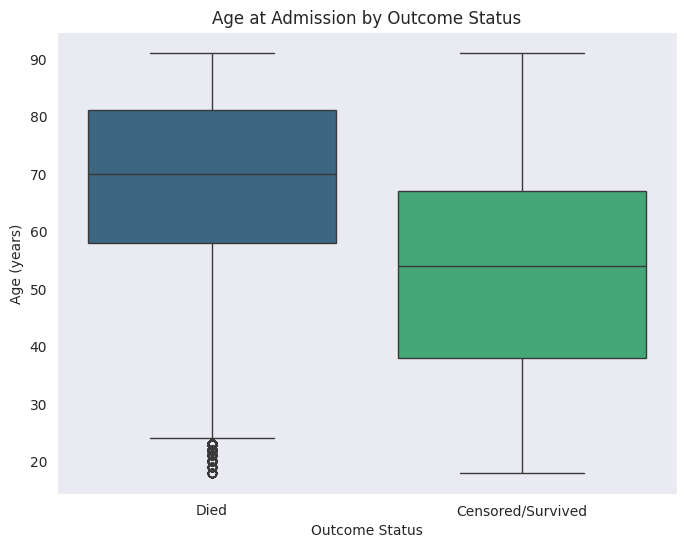

Gender Distribution by Outcome Status:


'Counts:'

gender,F,M
outcome_status,,
Censored/Survived,175019,150204
Died,49675,56051


'Percentages:'

gender,F,M
outcome_status,,
Censored/Survived,0.538151,0.461849
Died,0.469847,0.530153


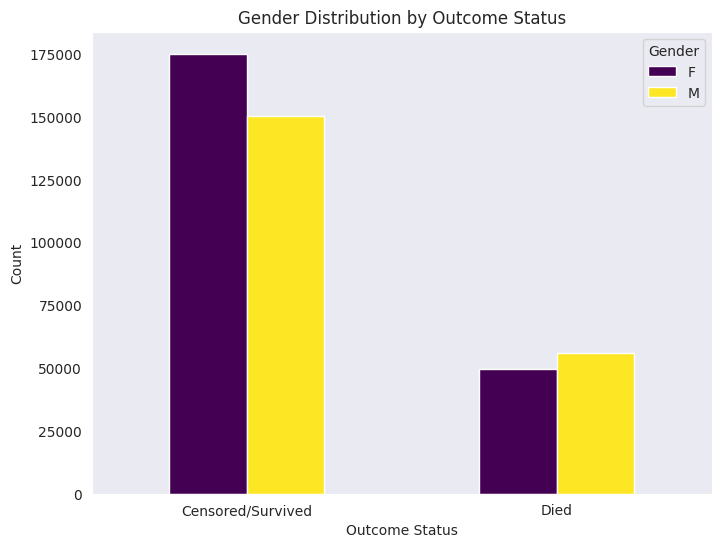


Admission Type Distribution by Outcome Status:


'Counts (Top 5 types):\n'

admission_type,EU OBSERVATION,EW EMER.,OBSERVATION ADMIT,SURGICAL SAME DAY ADMISSION,URGENT
outcome_status,,,,,
Censored/Survived,82065,97223,38670,29790,36273
Died,12748,52199,13714,4348,8448


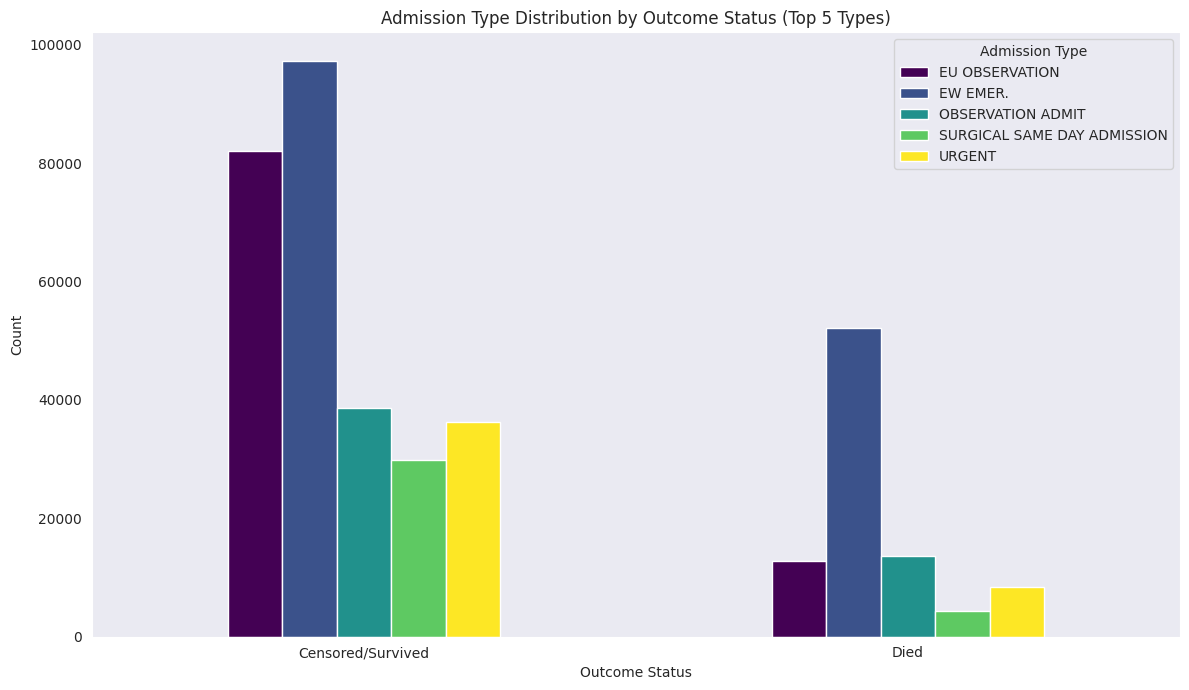

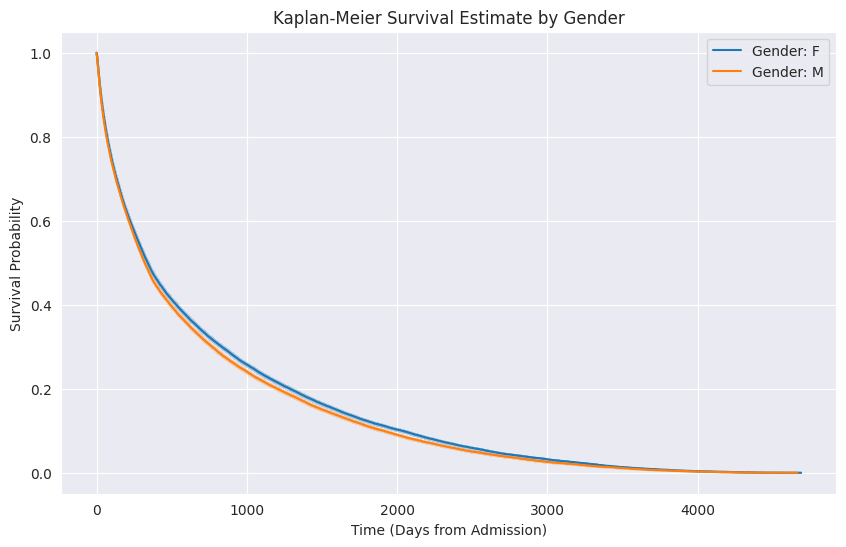

In [ ]:
kmf = KaplanMeierFitter()
merged_df['outcome_status'] = merged_df['event'].map({1: 'Died', 0: 'Censored/Survived'})

# Compare Age by Outcome
print("Age at Admission by Outcome Status:")
display(merged_df.groupby('outcome_status')['age_at_admission'].describe())
plt.figure(figsize=(8, 6))
sns.boxplot(x='outcome_status', y='age_at_admission', data=merged_df, palette='viridis')
plt.title('Age at Admission by Outcome Status')
plt.xlabel('Outcome Status')
plt.ylabel('Age (years)')
plt.show()


# Compare Gender by Outcome
print("Gender Distribution by Outcome Status:")
gender_outcome_counts = merged_df.groupby(['outcome_status', 'gender']).size().unstack(fill_value=0)
gender_outcome_perc = gender_outcome_counts.apply(lambda x: x / x.sum(), axis=1)
display("Counts:", gender_outcome_counts)
display("Percentages:", gender_outcome_perc)
gender_outcome_counts.plot(kind='bar', stacked=False, figsize=(8, 6), rot=0, colormap='viridis')
plt.title('Gender Distribution by Outcome Status')
plt.xlabel('Outcome Status')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()


# Compare Admission Type by Outcome
print("\nAdmission Type Distribution by Outcome Status:")
admtype_outcome_counts = merged_df.groupby(['outcome_status', 'admission_type']).size().unstack(fill_value=0)

# Only plot top N admission types for clarity if there are many
top_types = merged_df['admission_type'].value_counts().index[:5]
admtype_outcome_counts = admtype_outcome_counts.loc[:, admtype_outcome_counts.columns.isin(top_types)]
display("Counts (Top 5 types):\n", admtype_outcome_counts)

admtype_outcome_counts.plot(kind='bar', stacked=False, figsize=(12, 7), rot=0, colormap='viridis')
plt.title('Admission Type Distribution by Outcome Status (Top 5 Types)')
plt.xlabel('Outcome Status')
plt.ylabel('Count')
plt.legend(title='Admission Type')
plt.tight_layout()
plt.show()

# Stratified Kaplan-Meier Curve (Example: by Gender)
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

for gender_value in merged_df['gender'].unique():
    mask = merged_df['gender'] == gender_value
    kmf.fit(
        durations=merged_df[mask]['duration'],
        event_observed=merged_df[mask]['event'],
        label=f'Gender: {gender_value}'
    )
    kmf.plot_survival_function(ax=ax)

plt.title('Kaplan-Meier Survival Estimate by Gender')
plt.xlabel('Time (Days from Admission)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

## Insights:

1. Age: Patients who died tend to be older, with a median age higher than those who survived. The age distribution for deceased patients is skewed towards the upper limit.
Observation Duration:

2. Observation Duartion: Deceased patients generally have longer observation durations compared to censored/survived patients. The duration distribution is highly skewed, with some outliers having very long stays.

3. Gender Distribution: Gender distribution is fairly balanced across outcomes, it may not be a strong predictor of time to death.

1.